In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
dataset = pd.read_csv('/gdrive/My Drive/BigCarAds.csv')

Mounted at /gdrive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dataset.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [4]:
dataset.isna().sum()/ len(dataset) * 100 > 30


maker                  False
model                   True
mileage                False
manufacture_year       False
engine_displacement    False
engine_power           False
body_type               True
color_slug              True
stk_year                True
transmission           False
door_count             False
seat_count             False
fuel_type               True
date_created           False
date_last_seen         False
price_eur              False
dtype: bool

#Dropping the columns with more than 30% null values

In [0]:
dataset = dataset.drop(['model', 'body_type', 'color_slug', 'stk_year', 'fuel_type'], axis = 1)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552912 entries, 0 to 3552911
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   maker                object 
 1   mileage              float64
 2   manufacture_year     float64
 3   engine_displacement  float64
 4   engine_power         float64
 5   transmission         object 
 6   door_count           object 
 7   seat_count           object 
 8   date_created         object 
 9   date_last_seen       object 
 10  price_eur            float64
dtypes: float64(5), object(6)
memory usage: 298.2+ MB


#Converting the possible float values to float

In [7]:
dataset.door_count[dataset.door_count == 'None'] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
dataset.seat_count[dataset.seat_count == 'None'] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
dataset.door_count = dataset.door_count.astype(float)
dataset.seat_count = dataset.seat_count.astype(float)

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552912 entries, 0 to 3552911
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   maker                object 
 1   mileage              float64
 2   manufacture_year     float64
 3   engine_displacement  float64
 4   engine_power         float64
 5   transmission         object 
 6   door_count           float64
 7   seat_count           float64
 8   date_created         object 
 9   date_last_seen       object 
 10  price_eur            float64
dtypes: float64(7), object(4)
memory usage: 298.2+ MB


# Handling the date date values

In [0]:
dataset.date_last_seen = pd.to_datetime(dataset.date_last_seen)

In [0]:
dataset.date_created = pd.to_datetime(dataset.date_created)

## Adding new feature ads_duration using the date_created and date_last_seen

In [0]:
dataset['ads_duration'] = (dataset.date_last_seen - dataset.date_created)

In [0]:
dataset.ads_duration = (dataset.ads_duration / np.timedelta64(1, 'D')).astype(float)

In [0]:
dataset = dataset.drop(['date_created', 'date_last_seen'], axis=1)

## Converting the manufacture_year from their manufactured year to years since they have been manufactured

In [0]:
dataset['manufacture_year'] = 2020 - dataset.manufacture_year

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552912 entries, 0 to 3552911
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   maker                object 
 1   mileage              float64
 2   manufacture_year     float64
 3   engine_displacement  float64
 4   engine_power         float64
 5   transmission         object 
 6   door_count           float64
 7   seat_count           float64
 8   price_eur            float64
 9   ads_duration         float64
dtypes: float64(8), object(2)
memory usage: 271.1+ MB


In [0]:
dataset.ads_duration = dataset.ads_duration.apply(np.float)

# Outlier Detection and Removal for numerical values

## Outliers Detection and Trimming from Manufacture year Column using Interquartile Range

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(0.0, 250.0)

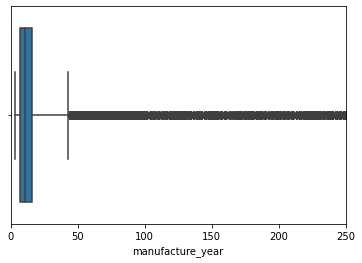

In [19]:
import seaborn as sns
sns.boxplot(dataset['manufacture_year'], whis= 3)
plt.xlim(0, 250)

In [0]:
def find_boundaries(df, variable, distance):
  IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
  lower_boundary = df[variable].quantile(0.25) - (IQR *distance)
  upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
  return upper_boundary, lower_boundary

In [21]:
m_upper, m_lower = find_boundaries(dataset, 'manufacture_year', 1.5)
m_upper, m_lower

(29.5, -6.5)

In [22]:
outliers_rm = np.where(dataset['manufacture_year'] > m_upper, True,
                       np.where(dataset['manufacture_year']< m_lower, True, False))

outliers_rm

array([False, False, False, ..., False, False, False])

(0.0, 250.0)

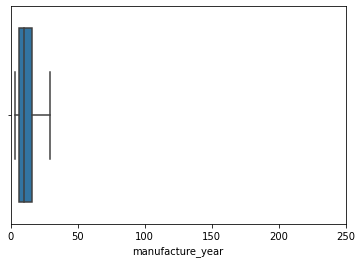

In [23]:
dataset_trimmed = dataset.loc[~(outliers_rm)]
dataset = dataset_trimmed
sns.boxplot(dataset['manufacture_year'])
plt.xlim(0,250)

## Outlier detection and winsorization for mileage column

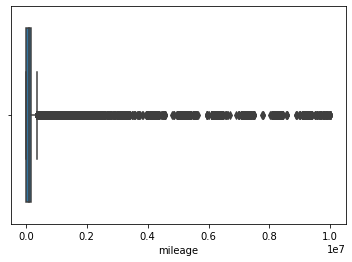

In [24]:
sns.boxplot(dataset['mileage'])

In [0]:
def winsorize(df, variable, upper_limit, lower_limit):
  return np.where(df[variable] > upper_limit,upper_limit,
                  np.where(df[variable]< lower_limit, lower_limit,
                           df[variable]))

In [0]:
dataset['mileage'] = winsorize(dataset, 'mileage', dataset['mileage'].quantile(0.95),
                               dataset['mileage'].quantile(0.05))


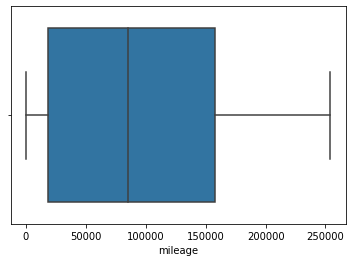

In [27]:
sns.boxplot(dataset['mileage'])

## Outlier detection and winsorization for engine_displacement column

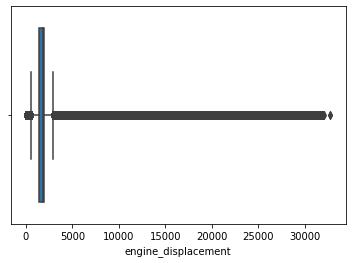

In [28]:
sns.boxplot(dataset['engine_displacement'])

In [0]:
dataset['engine_displacement'] = winsorize(dataset, 'engine_displacement', dataset['engine_displacement'].quantile(0.95),
                               dataset['engine_displacement'].quantile(0.05))

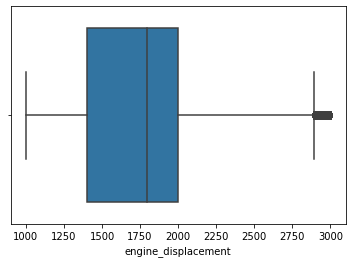

In [30]:
sns.boxplot(dataset['engine_displacement'])

## Outlier detection and winsorization for engine_power column

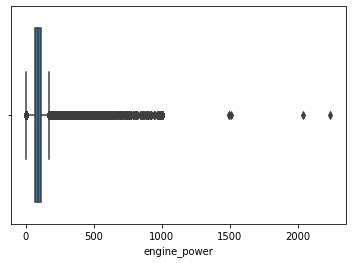

In [31]:
sns.boxplot(dataset['engine_power'])

In [0]:
dataset['engine_power'] = winsorize(dataset, 'engine_power', dataset['engine_power'].quantile(0.95),
                               dataset['engine_power'].quantile(0.05))

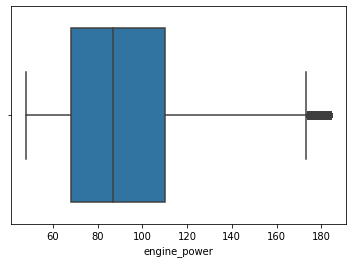

In [33]:
sns.boxplot(dataset['engine_power'])

## Outlier Detection and Trimming of door_count and seat_count

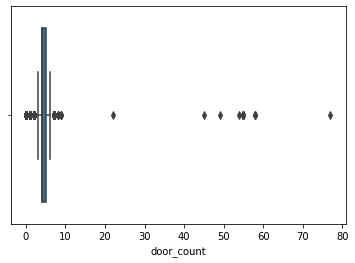

In [34]:
sns.boxplot(dataset['door_count'])

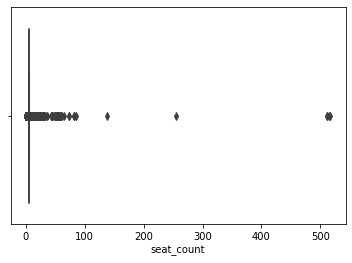

In [35]:
sns.boxplot(dataset['seat_count'])

In [0]:
dataset['door_count'] = winsorize(dataset, 'door_count', dataset['door_count'].quantile(0.95),
                               dataset['door_count'].quantile(0.05))
dataset['seat_count'] = winsorize(dataset, 'seat_count', dataset['seat_count'].quantile(0.95),
                               dataset['seat_count'].quantile(0.05))

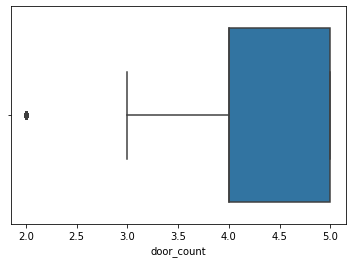

In [37]:
sns.boxplot(dataset['door_count'])

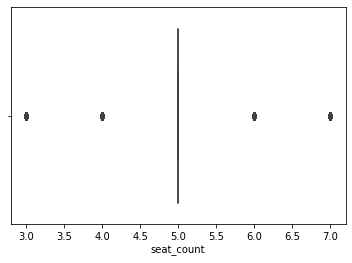

In [38]:
sns.boxplot(dataset['seat_count'])

##Outlier Detection for ads_duration column

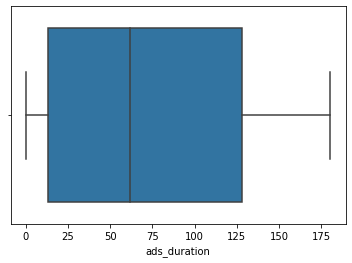

In [39]:
sns.boxplot(dataset['ads_duration'])

# Imputing Categorical Values

In [40]:
dataset.info(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3475300 entries, 0 to 3552911
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   maker                object 
 1   mileage              float64
 2   manufacture_year     float64
 3   engine_displacement  float64
 4   engine_power         float64
 5   transmission         object 
 6   door_count           float64
 7   seat_count           float64
 8   price_eur            float64
 9   ads_duration         float64
dtypes: float64(8), object(2)
memory usage: 291.7+ MB


In [41]:
dataset.maker= dataset.maker.astype(str)
dataset.info()
dataset.maker[dataset.maker == 'nan']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3475300 entries, 0 to 3552911
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   maker                object 
 1   mileage              float64
 2   manufacture_year     float64
 3   engine_displacement  float64
 4   engine_power         float64
 5   transmission         object 
 6   door_count           float64
 7   seat_count           float64
 8   price_eur            float64
 9   ads_duration         float64
dtypes: float64(8), object(2)
memory usage: 291.7+ MB


9          nan
10         nan
11         nan
12         nan
16         nan
          ... 
3551860    nan
3551861    nan
3551863    nan
3552082    nan
3552084    nan
Name: maker, Length: 498805, dtype: object

In [42]:
dataset.maker.mode()

0    nan
dtype: object

In [43]:
dataset['maker'][dataset.maker == 'nan'] = 'skoda'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3475300 entries, 0 to 3552911
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   maker                object 
 1   mileage              float64
 2   manufacture_year     float64
 3   engine_displacement  float64
 4   engine_power         float64
 5   transmission         object 
 6   door_count           float64
 7   seat_count           float64
 8   price_eur            float64
 9   ads_duration         float64
dtypes: float64(8), object(2)
memory usage: 291.7+ MB


In [0]:
dataset['transmission'] = dataset.transmission.astype(str)

In [46]:
dataset.transmission.mode()

0    man
dtype: object

In [47]:
dataset['transmission'][dataset.transmission == 'nan'] = 'man'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3475300 entries, 0 to 3552911
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   maker                object 
 1   mileage              float64
 2   manufacture_year     float64
 3   engine_displacement  float64
 4   engine_power         float64
 5   transmission         object 
 6   door_count           float64
 7   seat_count           float64
 8   price_eur            float64
 9   ads_duration         float64
dtypes: float64(8), object(2)
memory usage: 291.7+ MB


# Encoding Categorical values 

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_enc = LabelEncoder()

dataset['maker'] = label_enc.fit_transform(dataset['maker'])
dataset['transmission'] = label_enc.fit_transform(dataset['transmission'])



In [0]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'),[0])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                                         # Leave the rest of the columns untouched
)

# onehot_enc = OneHotEncoder(['maker', 'transmission'])
dataset = pd.DataFrame.sparse.from_spmatrix(ct.fit_transform(dataset))

In [51]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151000.0,9.0,2000.0,103.0,1.0,5.0,7.0,10584.75,74.104266
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143476.0,8.0,2000.0,81.0,1.0,5.0,5.0,8882.31,74.104266
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97676.0,10.0,1995.0,85.0,1.0,5.0,5.0,12065.06,74.104266
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111970.0,16.0,1200.0,48.0,1.0,5.0,5.0,2960.77,74.104266
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128886.0,16.0,1200.0,48.0,1.0,5.0,5.0,2738.71,74.104266


# Imputing Numerical values

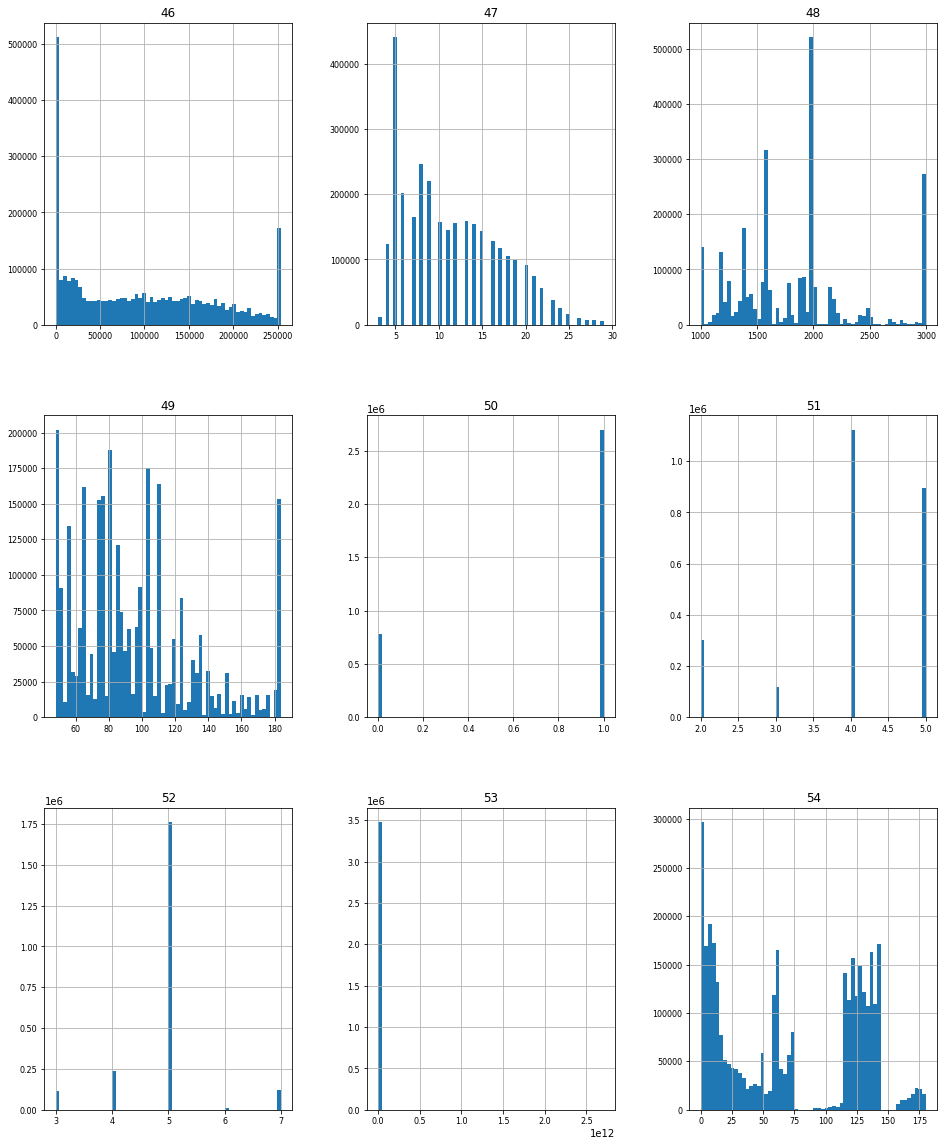

In [52]:
dataset_num = dataset.drop(range(0,46), axis = 1)
dataset_num.hist(figsize=(16, 20), bins=60, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


Since none of the features seem to follow normal distribution, we will use median to impute the data instead of mean.

In [0]:
from sklearn.impute import SimpleImputer
columns = dataset.columns
imputer = SimpleImputer(strategy='median')
dataset = imputer.fit_transform(dataset)

In [0]:
dataset = pd.DataFrame(dataset)

In [55]:
dataset.isnull().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
dtype: bool

In [56]:
cols = list(dataset.columns)
cols[46:] = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'transmission', 'door_count', 'seat_count', 'price_eur', 'ads_duration']
len(cols)

55

In [0]:
dataset.columns = cols

In [58]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,mileage,manufacture_year,engine_displacement,engine_power,transmission,door_count,seat_count,price_eur,ads_duration
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151000.0,9.0,2000.0,103.0,1.0,5.0,7.0,10584.75,74.104266
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143476.0,8.0,2000.0,81.0,1.0,5.0,5.0,8882.31,74.104266
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97676.0,10.0,1995.0,85.0,1.0,5.0,5.0,12065.06,74.104266
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111970.0,16.0,1200.0,48.0,1.0,5.0,5.0,2960.77,74.104266
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128886.0,16.0,1200.0,48.0,1.0,5.0,5.0,2738.71,74.104266


# Log transforming the dependent variable price_eur

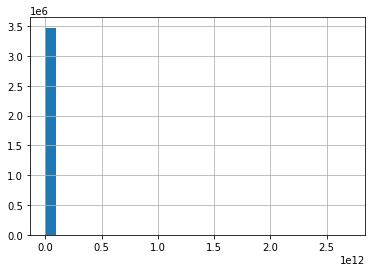

In [59]:
dataset['price_eur'].hist(bins=30)

In [0]:
dataset['price_eur'] = np.log(dataset['price_eur'])

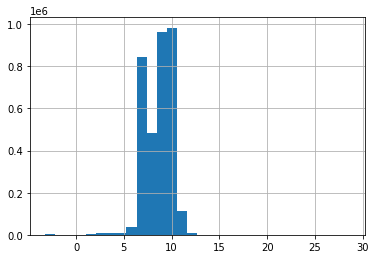

In [61]:
dataset.price_eur.hist(bins=30)

# Visualizing Variable Correlation 

In [62]:
dataset.corr()['price_eur']['mileage':]

mileage               -0.452595
manufacture_year      -0.532419
engine_displacement    0.121616
engine_power           0.351507
transmission          -0.324499
door_count            -0.027380
seat_count            -0.014943
price_eur              1.000000
ads_duration           0.334016
Name: price_eur, dtype: float64

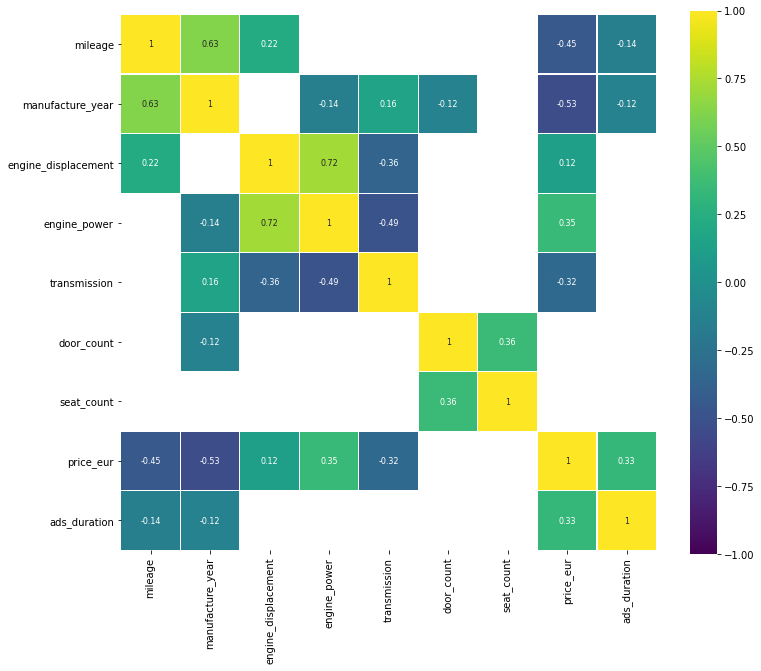

In [63]:
corr = dataset.drop(range(0,46), axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [0]:
dataset['door_to_seat'] = dataset['door_count'] / dataset['seat_count']

In [65]:
dataset.corr()['price_eur']['mileage':]

mileage               -0.452595
manufacture_year      -0.532419
engine_displacement    0.121616
engine_power           0.351507
transmission          -0.324499
door_count            -0.027380
seat_count            -0.014943
price_eur              1.000000
ads_duration           0.334016
door_to_seat          -0.015549
Name: price_eur, dtype: float64

In [0]:
dataset = dataset.drop('door_to_seat', axis = 1)

In [0]:
X = dataset.drop('price_eur', axis=1)
y = dataset['price_eur']

In [68]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,mileage,manufacture_year,engine_displacement,engine_power,transmission,door_count,seat_count,ads_duration
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151000.0,9.0,2000.0,103.0,1.0,5.0,7.0,74.104266
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143476.0,8.0,2000.0,81.0,1.0,5.0,5.0,74.104266
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97676.0,10.0,1995.0,85.0,1.0,5.0,5.0,74.104266
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111970.0,16.0,1200.0,48.0,1.0,5.0,5.0,74.104266
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128886.0,16.0,1200.0,48.0,1.0,5.0,5.0,74.104266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54000.0,7.0,1200.0,63.0,1.0,4.0,5.0,0.000000
3475296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85430.0,20.0,1796.0,50.0,1.0,4.0,5.0,0.000000
3475297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230000.0,14.0,1900.0,100.0,1.0,4.0,5.0,0.000000
3475298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85430.0,19.0,1796.0,87.0,1.0,4.0,5.0,0.000000


In [69]:
y

0          9.267170
1          9.091817
2          9.398069
3          7.993205
4          7.915242
             ...   
3475295    7.166528
3475296    7.166528
3475297    7.166528
3475298    7.166528
3475299    7.166528
Name: price_eur, Length: 3475300, dtype: float64

# Train test split



In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Feature Scaling

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)